In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
test_results = pd.read_csv("../../data/metrics/proposed-sample.csv")
training_locations = pd.read_csv("../../data/latlongs/training_plots.csv")
testing_locations = pd.read_csv("../../data/latlongs/test_plots.csv")
test_results.drop('Unnamed: 0', axis = 1, inplace = True)

In [5]:
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km

def calc_distance(test_idx):
    lat1 = radians(testing_locations['lats'][test_idx])
    lon1 = radians(testing_locations['longs'][test_idx])
    
    distances = []
    for train_idx in range(0, len(training_locations)):
        lat2 = radians(training_locations['lats'][train_idx])
        lon2 = radians(training_locations['longs'][train_idx])
        R = 6373.0

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        distance = R * c
        distances.append(distance)
    min_distance = np.min(distances)
    dist_50 = int(np.percentile(distances, (50 / 4231)))
    print(f"The min distance is: {int(min_distance)}")
    return min_distance, dist_50

In [6]:
mins = []
fifties = []
for i in range(0, len(testing_locations)):
    d_min, d_50 = calc_distance(i)
    mins.append(d_min)
    fifties.append(d_50)

The min distance is: 163
The min distance is: 104
The min distance is: 59
The min distance is: 108
The min distance is: 22
The min distance is: 15
The min distance is: 78
The min distance is: 18
The min distance is: 92
The min distance is: 41
The min distance is: 15
The min distance is: 227
The min distance is: 195
The min distance is: 242
The min distance is: 182
The min distance is: 51
The min distance is: 14
The min distance is: 72
The min distance is: 18
The min distance is: 22
The min distance is: 50
The min distance is: 151
The min distance is: 163
The min distance is: 43
The min distance is: 26
The min distance is: 27
The min distance is: 19
The min distance is: 14
The min distance is: 152
The min distance is: 90
The min distance is: 79
The min distance is: 33
The min distance is: 98
The min distance is: 31
The min distance is: 1
The min distance is: 150
The min distance is: 20
The min distance is: 3
The min distance is: 53
The min distance is: 48
The min distance is: 70
The min

KeyboardInterrupt: 

In [ ]:
testing_locations['min_d'] = mins
testing_locations['50_d'] = fifties

In [299]:
#testing_locations.to_csv("../data/latlongs/test_plots.csv")

In [4]:
testing = testing_locations.join(test_results, how = 'inner')

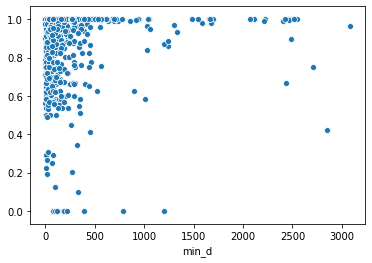

In [8]:
precision = testing['tp_soft'] / (testing['tp_soft'] + testing['fp_soft'])
recall = testing['tp_soft'] / (testing['tp_soft'] + testing['fn_soft'])
f1_soft = (precision + recall) / 2
sns.scatterplot(testing['min_d'], f1_soft)

In [5]:
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

precision = testing['tp_soft'] / (testing['tp_soft'] + testing['fp_soft'])
recall = testing['tp_soft'] / (testing['tp_soft'] + testing['fn_soft'])
f1s = 2 * ((precision * recall) / (precision + recall))

min_distances = [x for x in range(10, 500, 10)]
group = [[0, 10], [20, 30], [40, 50], [60, 70, 80, 90]]
matrix = np.empty((len(min_distances), len(min_distances)))
std = np.empty((len(min_distances), len(min_distances)))
sizes = np.empty((len(min_distances), len(min_distances)))

for idx, dist in enumerate(min_distances):
    for idy, g in enumerate(group):
        #locs = (testing['min_d'] > dist)
        locs = np.logical_and( ((testing['min_d'] > (dist)) &
                                (testing['min_d'] < (1500))), [x in g for x in testing['group']])
        #if sum(locs) < 10:
        #    print(f"ERROR less than 10 at {dist}")
        #precision = np.sum(testing['tp_soft'][locs]) / np.sum((testing['tp_soft'][locs] + testing['fp_soft'][locs]))
        #recall = np.sum(testing['tp_soft'][locs]) / np.sum((testing['tp_soft'][locs] + testing['fn_soft'][locs]))
        #f1_soft = 2 * ((precision * recall) / (precision + recall))
        #f1_subsample = f1s[locs]
        #f1_subsample = f1_subsample[~np.isnan(f1_subsample)]
        #f1_baseline = f1s[np.logical_and([x in g for x in testing['group']],
        #                             testing['min_d'] < dist)]
        #f1_baseline = f1_baseline[~np.isnan(f1_baseline)]
        
        #se = mean_confidence_interval(f1_subsample)
        #se = np.std(f1_subsample) / np.sqrt(len(f1_subsample))
        #if idy == 0:
        #    print(np.mean(f1_baseline) - se, np.mean(f1_subsample) + se)
        #if idy == 0:
        #    print(dist, scipy.stats.mannwhitneyu(f1_baseline, f1_subsample))
        #print(f"At a minimum distance of {dist}, {g}, f1 is {np.mean(f1_soft)} for {sum(locs)}")
        mean_f1 = np.mean(f1s[locs])
        if mean_f1 > 1:
            mean_f1 = 1
        matrix[idx, idy] = mean_f1
        #std[idx, idy] = se
        sizes[idx, idy] = sum(locs)

In [11]:
from scipy import stats
stats.pearsonr(matrix[:, 0], [x for x in range(0, 39, 1)])[0]# ** 2

ValueError: operands could not be broadcast together with shapes (49,) (39,) 

In [8]:
matrix[:6, 0] = matrix[:6, 0] - 0.05

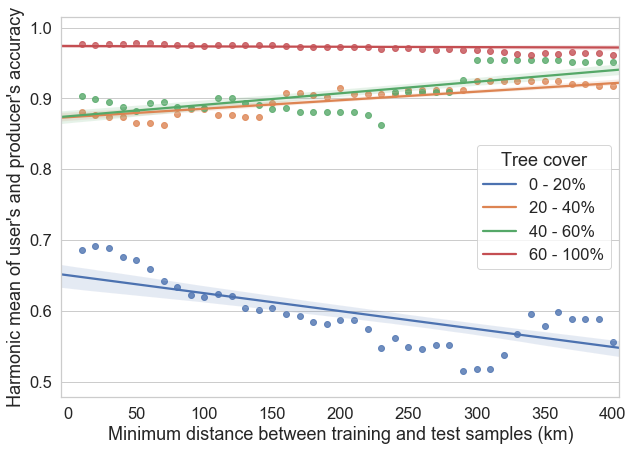

<Figure size 432x288 with 0 Axes>

In [6]:
plt.figure(figsize=(10, 7))
sns.set(font_scale = 1.5)
sns.set_style("white", {'legend.frameon':False, "font.family":"Times New Roman"})

ax1 = sns.regplot(min_distances, matrix[:, 0])
#sns.pointplot(231, 0.62)
#ax1.fill_between(min_distances, matrix[:, 0] - std[:, 0], matrix[:, 0] + std[:, 0], alpha = 0.3)

ax2 = sns.regplot(min_distances, matrix[:, 1])
#ax2 = sns.lineplot(min_distances, matrix[:, 1])
#ax2.fill_between(min_distances, matrix[:, 1] - std[:, 1], matrix[:, 1] + std[:, 1], alpha = 0.3)

#ax3 = sns.lineplot(min_distances, matrix[:, 2])
ax3 = sns.regplot(min_distances, matrix[:, 2])
ax3 = sns.regplot(min_distances, matrix[:, 3])
#ax3.fill_between(min_distances, matrix[:, 2] - std[:, 2], matrix[:, 2] + std[:, 2], alpha = 0.2)
plt.legend(labels=['0 - 20%', '20 - 40%', '40 - 60%', '60 - 100%'], title = 'Tree cover')
plt.xlabel("Minimum distance between training and test samples (km)")
plt.ylabel("Harmonic mean of user's and producer's accuracy")
#ax2.set_xticks((0, 25, 75, 125, 175, 225, 275, 325, 375, 425, 475))
ax2.xaxis.grid(False)
ax2.set(xlim = (-5, 405))
fig1 = plt.gcf()
plt.show()
plt.draw()
#fig1.savefig('../references/pdf/spatial-correlation.pdf')





#sns.lineplot(min_distances, matrix[:, 3])
#sns.lineplot(min_distances, matrix[:, 4])

In [694]:
np.percentile(mins, 95)

1005.6196331013086

In [426]:
locs = (testing['min_d'] > 6)
f1s_50 = f1s[locs]
f1s_50 = f1s_50[~np.isnan(f1s_50)]
f1s_all = f1s[~locs]
f1s_all = f1s_all[~np.isnan(f1s_all)]

scipy.stats.mannwhitneyu(f1s_50, f1s_all, alternative = 'two-sided')

MannwhitneyuResult(statistic=22251.0, pvalue=0.0036494247107721495)

In [454]:
f1, min_distance, n_tp

224.7470789185429

In [414]:
np.mean(f1s_50)

0.8902331516475612

In [415]:
len(f1s_all)

639

In [416]:
len(f1s_50)

116

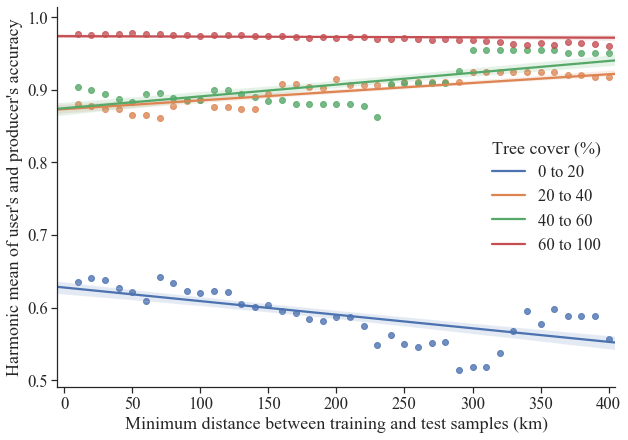

<Figure size 432x288 with 0 Axes>

In [9]:
plt.figure(figsize=(10, 7))
sns.set(font_scale = 1.5)
sns.set_style("white", {'legend.frameon':False, "font.family":"Times New Roman"})
ax1 = sns.regplot(min_distances, matrix[:, 0])
#sns.pointplot(231, 0.62)
#ax1.fill_between(min_distances, matrix[:, 0] - std[:, 0], matrix[:, 0] + std[:, 0], alpha = 0.3)

ax2 = sns.regplot(min_distances, matrix[:, 1])
#ax2 = sns.lineplot(min_distances, matrix[:, 1])
#ax2.fill_between(min_distances, matrix[:, 1] - std[:, 1], matrix[:, 1] + std[:, 1], alpha = 0.3)

#ax3 = sns.lineplot(min_distances, matrix[:, 2])
ax3 = sns.regplot(min_distances, matrix[:, 2])
ax3 = sns.regplot(min_distances, matrix[:, 3])
#ax3.fill_between(min_distances, matrix[:, 2] - std[:, 2], matrix[:, 2] + std[:, 2], alpha = 0.2)
plt.legend(labels=['0 to 20', '20 to 40', '40 to 60', '60 to 100'], title = 'Tree cover (%)', framealpha=0.0)
plt.xlabel("Minimum distance between training and test samples (km)")
plt.ylabel("Harmonic mean of user's and producer's accuracy")
#plt.box(on=None)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
#ax2.set_xticks((0, 25, 75, 125, 175, 225, 275, 325, 375, 425, 475))
ax2.xaxis.grid(False)
ax2.set(xlim = (-5, 405))
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('../../references/highquality/figure9.pdf', dpi = 300)


In [3]:
rf = pd.read_csv("../../data/metrics/rf.csv")
svm = pd.read_csv("../../data/metrics/svm.csv")
unet = pd.read_csv("../../data/metrics/unet.csv")
new_metrics = pd.read_csv("../../data/metrics/proposed.csv")
metrics = pd.concat([new_metrics, unet, svm, rf])

#rf = pd.read_csv("../data/metrics/random_forest.csv")
svm = pd.read_csv("../../data/metrics/svm-sample.csv")
unet = pd.read_csv("../../data/metrics/unet-sample.csv")
proposed = pd.read_csv("../../data/metrics/proposed-sample.csv")
rf = pd.read_csv("../../data/metrics/rf-sample.csv")
#metrics['model'] = 'proposed'
sample = pd.concat([proposed, unet, svm, rf])


/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


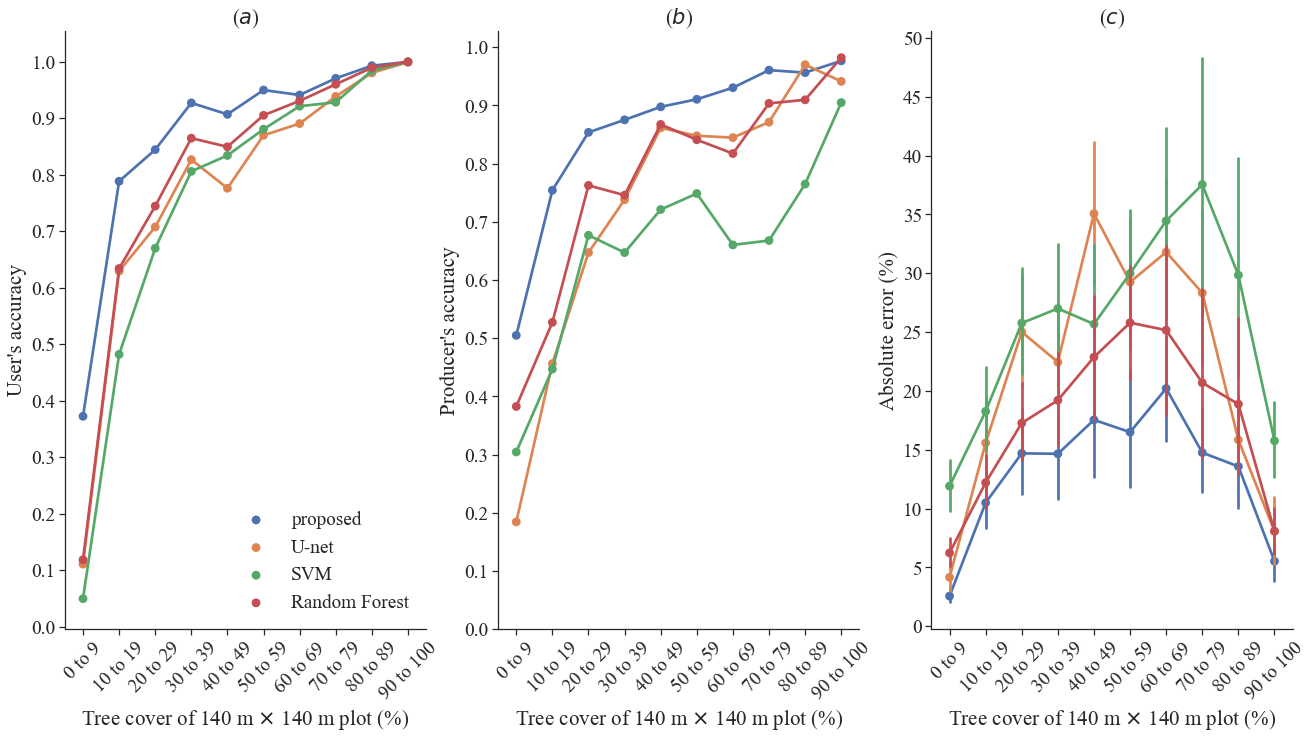

<Figure size 432x288 with 0 Axes>

In [8]:
# Hard F1, Soft F1, Error
f, ((c1r1, c1r2, c1r3)) = plt.subplots(1, 3, sharey=False)
from matplotlib import rc
rc('text', usetex=False)
f.set_size_inches(22, 11.)
sns.set_style("white", {'legend.frameon':False})
sns.set(font_scale = 1.75)

c1r1.set_title(r"($\it{a}$)")
one = sns.pointplot(x = 'group', y= 'soft_prec',
    data=metrics, hue = 'model', ax = c1r1)#, style = 'variable')
one.set_xticklabels(rotation=45, labels = ['0 to 9', '10 to 19', '20 to 29', '30 to 39', '40 to 49', '50 to 59',
                     '60 to 69', '70 to 79', '80 to 89', '90 to 100'])
one.set(xlabel="Tree cover of 140 m " + r"$\times$ " + "140 m plot (%)", ylabel = "User's accuracy")
one.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
one.legend(fontsize='small')
one.spines['right'].set_visible(False)
one.spines['top'].set_visible(False)
one.yaxis.set_ticks_position('left')
one.xaxis.set_ticks_position('bottom')

c1r2.set_title(r"($b$)")
two = sns.pointplot(x = 'group', y= 'soft_rec',
    data=metrics, hue = 'model', ax = c1r2)
two.set_xticklabels(rotation=45, labels = ['0 to 9', '10 to 19', '20 to 29', '30 to 39', '40 to 49', '50 to 59',
                     '60 to 69', '70 to 79', '80 to 89', '90 to 100'])
two.set(xlabel="Tree cover of 140 m " + r"$\times$ " + "140 m plot (%)", ylabel = "Producer's accuracy")
two.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
two.spines['right'].set_visible(False)
two.spines['top'].set_visible(False)
two.yaxis.set_ticks_position('left')
two.xaxis.set_ticks_position('bottom')

#c1r3.set_title("(" + r"\textit{" + "c" + "}" + ")")
c1r3.set_title(r"($c$)")
three = sns.pointplot(x = 'group', y= 'error',
    data=sample, hue = 'model', ax = c1r3)#, style = 'variable')
three.set_xticklabels(rotation=45, labels = ['0 to 9', '10 to 19', '20 to 29', '30 to 39', '40 to 49', '50 to 59',
                     '60 to 69', '70 to 79', '80 to 89', '90 to 100'])
three.set(xlabel="Tree cover of 140 m " + r"$\times$ " + "140 m plot (%)", ylabel = "Absolute error (%)")
three.set_yticks([0, 5, 10, 15, 20, 25, 30,35, 40,45, 50])
three.spines['right'].set_visible(False)
three.spines['top'].set_visible(False)
three.yaxis.set_ticks_position('left')
three.xaxis.set_ticks_position('bottom')

sns.set_style("white", {'legend.frameon':False, "font.family":"Times New Roman"})
legend = one.legend(framealpha=0.0)
legend.get_frame().set_facecolor('none')

two.legend_.remove()
three.legend_.remove()
#plt.show()
fig1 = plt.gcf()
sns.set_style("white", {'legend.frameon':False, "font.family":"Times New Roman"})
plt.show()
plt.draw()
fig1.savefig('../../references/highquality/figure8.pdf')

